# Healy chapter 7 figures (2022-09-03)

_by A. Maurits van der Veen_  

_Modification history:_  
_2022-08-20 - Initial version_  
_2022-09-03 - Clean-up_  

This notebook provides python code to parallel the R code in Healy's Data Visualization book. 

It uses the `plotnine` module in python, which replicates most of ggplot.


## 0. General preparation

The code relies on several python modules, which may need to be installed first. To do so, uncomment the next X code snippets.

- `plotnine` is the main module replicating ggplot
- `mizani` provides axis label formatting
- `pyreadr` reads R-format datasets
- `adjustText` is used to move text around to avoid overlapping (alternative to ggrepel)
- `patchworklib` makes compound charts possible


In [1]:
# !pip install plotnine


In [2]:
# !pip install mizani


In [3]:
# !pip install pyreadr


In [4]:
# !pip install adjustText


In [5]:
# !pip install patchworklib


In [6]:
import math
import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt

import patchworklib as pw

from plotnine import *  # alternative: import plotnine as p9 and always use prefix
from mizani.formatters import currency_format, percent_format

import adjustText

import pyreadr

import urllib.request


<Figure size 72x72 with 0 Axes>

## Chapter 7 - Draw Maps

The headings below correspond to chapter sections in the book (and share the same titles). 

In [7]:
localfolder = '/Users/yourname/Downloads/'  # Change to local path


In [8]:
# Retrieve and load data frames provided by Healy for the book

remotefolder = 'https://github.com/kjhealy/socviz/blob/master/data/'

datasetname = 'election'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', 
                      localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
election = newdata[datasetname]

datasetname = 'county_data'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', 
                      localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
county_data = newdata[datasetname]

datasetname = 'opiates'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', 
                      localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
opiates = newdata[datasetname]


In [9]:
# Retrieve and load US-state-based geojson files
# (I use the 20m file, but there are higher resolution alternatives too;
#  see https://eric.clst.org/tech/usgeojson/)

remotefolder = 'https://eric.clst.org/assets/wiki/uploads/Stuff/'
targetfile = "gz_2010_us_040_00_20m.json"

urllib.request.urlretrieve(remotefolder + targetfile, localfolder + targetfile)

us_states_geo = gpd.read_file(localfolder + targetfile)

In [10]:
# Inspect the geojson dataframe
# Note that Healy uses a format that has individual observations (long, lat)
# for each point in the polygon; here, the whole polygon is a single obs (geometry)

us_states_geo.head()

GEO_ID STATE         NAME LSAD  CENSUSAREA  \
0  0400000US04    04      Arizona       113594.084   
1  0400000US05    05     Arkansas        52035.477   
2  0400000US06    06   California       155779.220   
3  0400000US08    08     Colorado       103641.888   
4  0400000US09    09  Connecticut         4842.355   

                                            geometry  
0  POLYGON ((-112.53859 37.00067, -112.53454 37.0...  
1  POLYGON ((-94.04296 33.01922, -94.04304 33.079...  
2  MULTIPOLYGON (((-120.24848 33.99933, -120.2473...  
3  POLYGON ((-107.31779 41.00296, -107.00061 41.0...  
4  POLYGON ((-72.39743 42.03330, -72.19883 42.030...

In [11]:
# Retrieve and load US county-level geojson data
# Here we do it directly, rather than copying to local first

remotefolder = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/'
targetfile = 'US-counties.geojson'

us_counties_geo = gpd.read_file(remotefolder + targetfile)
us_counties_geo.head()


id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  01001  0500000US01001    01    001   Autauga  County     594.436   
1  01009  0500000US01009    01    009    Blount  County     644.776   
2  01017  0500000US01017    01    017  Chambers  County     596.531   
3  01021  0500000US01021    01    021   Chilton  County     692.854   
4  01033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry  
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...  
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...  
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...  
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...

In [12]:
# Retrieve and load U.S. states as squares in geojson format
# For more info, see https://github.com/geobabbler/us-state-squares

remotefolder = 'https://github.com/geobabbler/us-state-squares/blob/master/'
targetfile = 'state_squares.geojson'
    
us_states_square = gpd.read_file(remotefolder + targetfile + '?raw=true')
us_states_square.head()

id abbr           name                                           geometry
0   1   ME          Maine  POLYGON ((-89.75000 45.75000, -88.75000 45.750...
1   2   NH  New Hampshire  POLYGON ((-89.75000 44.50000, -88.75000 44.500...
2   3   VT        Vermont  POLYGON ((-91.00000 44.50000, -90.00000 44.500...
3   4   MA  Massachusetts  POLYGON ((-91.00000 43.25000, -90.00000 43.250...
4   5   NY       New York  POLYGON ((-92.25000 43.25000, -91.25000 43.250...

### 7.1 Map U.S. State-Level Data


In [13]:
# See what the election data look like

election[['state', 'total_vote', 'r_points', 'pct_trump', 'party', 'census']].sample(n=5)

state  total_vote  r_points  pct_trump       party census
40  South Carolina   2103027.0     14.27      54.94  Republican  South
26         Montana    501822.0     20.24      55.65  Republican   West
46        Virginia   3982752.0     -5.32      44.43  Democratic  South
33  North Carolina   4741564.0      3.66      49.83  Republican  South
7         Delaware    443814.0    -11.38      41.71  Democratic  South

In [14]:
# Specify default colors for Democratic and Republican parties

party_colors = ("#2E74C0", "#CB454A")

In [15]:
# Add categorical variable based on sorted values

election = election.sort_values(by = ['r_points',], ascending = True)

varlist = list(election['state'])
state_cat = pd.Categorical(election['state'], categories=varlist)

# assign to a new column in the DataFrame
election = election.assign(state_cat = state_cat)


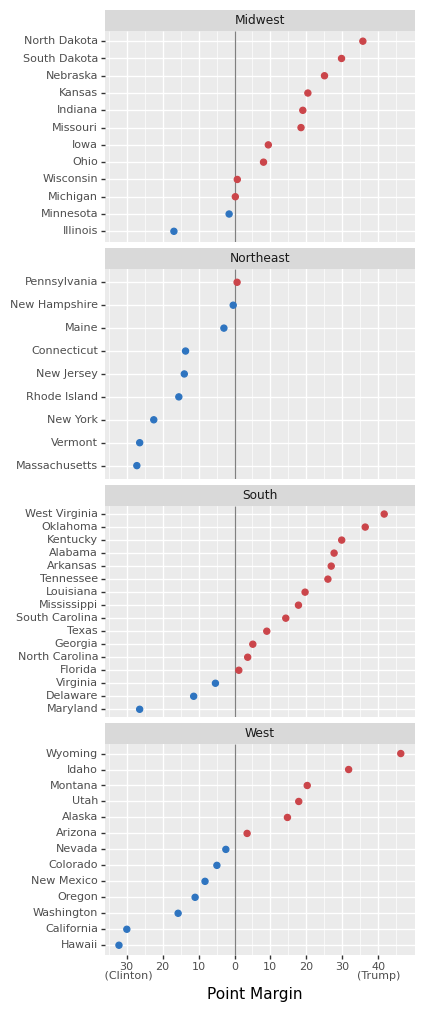

<ggplot: (310098779)>

In [16]:
# Figure 7.2

p = ggplot(data = election[election['st'] != "DC"],
           mapping = aes(x = 'r_points',
                         y = 'state_cat',
                         color = 'party'))

(p + geom_vline(xintercept = 0, color = "gray") +
     geom_point(size = 2) +
     scale_color_manual(values = party_colors) +
     scale_x_continuous(breaks = (-30, -20, -10, 0, 10, 20, 30, 40),
                        labels = ("30\n (Clinton)", "20", "10", "0",
                                  "10", "20", "30", "40\n(Trump)")) +
     facet_wrap('census', ncol=1, scales="free_y") +
     guides(color=False) + 
     labs(x = "Point Margin", y = "") +
     theme(axis_text = element_text(size=8),
           figure_size = (4, 12)) 
)


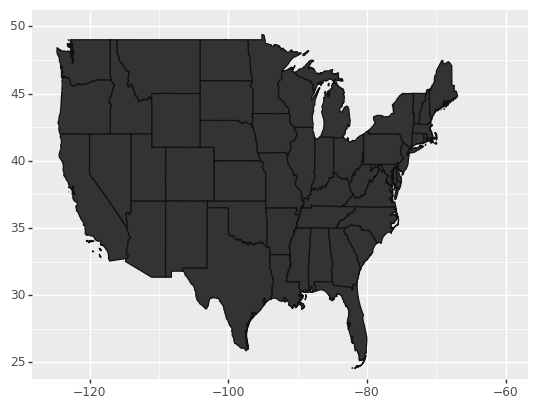

<ggplot: (310102845)>

In [17]:
# Figure 7.3
# Note that we use geom_map rather than geom_polygon & coord_map,
# since we have our full polygon geometry in each state observation

# Note, too that we need to set appropriate x- and y- limits to cut off Alaska and Hawaii
# (otherwise the contiguous 48 end up looking very small)

p = ggplot(data = us_states_geo)

(p + geom_map() + 
     xlim(-125, -60) +
     ylim(25, 50)
)
 

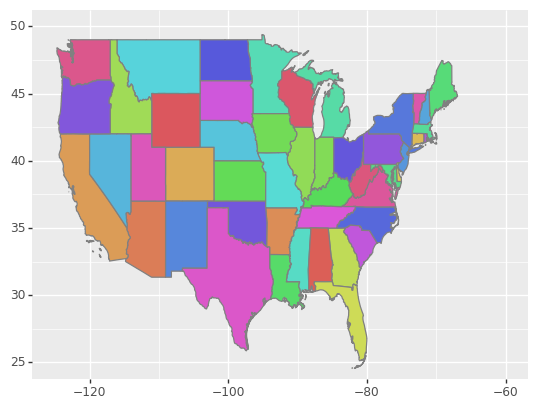

<ggplot: (309939179)>

In [18]:
# Figure 7.4

p = ggplot(data = us_states_geo,
           mapping = aes(fill = 'NAME'))

(p + geom_map(color = 'gray') + 
     guides(fill = False) +
     xlim(-125, -60) +
     ylim(25, 50)
)
 

In [19]:
# Check what the current projection ("coordinate reference system", or crs) is
# For more info on managing projections, see:
#    https://geopandas.org/en/stable/docs/user_guide/projections.html
# A list of common EPSG codes:
#    https://guides.library.duke.edu/r-geospatial/CRS (click on "EPSG codes for CRSs" tab)

us_states_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
# Remap to different projection
# (In Healy's code, this happens with the coord_map command to ggplot)

us_states_geoX = us_states_geo.to_crs("EPSG:3395")  # World Mercator

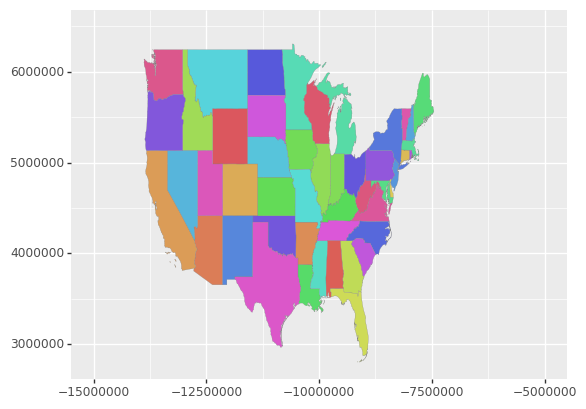

<ggplot: (310339109)>

In [21]:
# Figure 7.5a -> new projection
# Note that the relevant x- and y-limits are very different

p = ggplot(data = us_states_geoX,
           mapping = aes(fill = 'NAME'))

(p + geom_map(color = 'gray', size = 0.1) + 
     guides(fill = False) +
     xlim(-15000000, -5000000) +
     ylim(2800000, 6500000)
)


In [22]:
# Remap to different projection

us_states_geoY = us_states_geo.to_crs("EPSG:5070")  # Conus Albers

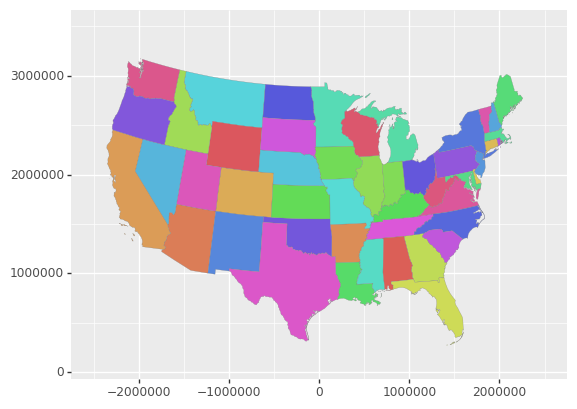

<ggplot: (310428013)>

In [23]:
# Figure 7.5b -> new projection

p = ggplot(data = us_states_geoY,
           mapping = aes(fill = 'NAME'))

(p + geom_map(color = 'gray', size = 0.1) + 
     guides(fill = False) +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000)
)


In [24]:
# Match state variable names with election df

us_states_geo.rename(columns = {'NAME': 'state',
                                'STATE': 'state_num'}, inplace = True)
us_states_geo.head()

GEO_ID state_num        state LSAD  CENSUSAREA  \
0  0400000US04        04      Arizona       113594.084   
1  0400000US05        05     Arkansas        52035.477   
2  0400000US06        06   California       155779.220   
3  0400000US08        08     Colorado       103641.888   
4  0400000US09        09  Connecticut         4842.355   

                                            geometry  
0  POLYGON ((-112.53859 37.00067, -112.53454 37.0...  
1  POLYGON ((-94.04296 33.01922, -94.04304 33.079...  
2  MULTIPOLYGON (((-120.24848 33.99933, -120.2473...  
3  POLYGON ((-107.31779 41.00296, -107.00061 41.0...  
4  POLYGON ((-72.39743 42.03330, -72.19883 42.030...

In [25]:
# Repeat for converted geo projection

us_states_geoY.rename(columns = {'NAME': 'state',
                                'STATE': 'state_num'}, inplace = True)
us_states_geoY.head()

GEO_ID state_num        state LSAD  CENSUSAREA  \
0  0400000US04        04      Arizona       113594.084   
1  0400000US05        05     Arkansas        52035.477   
2  0400000US06        06   California       155779.220   
3  0400000US08        08     Colorado       103641.888   
4  0400000US09        09  Connecticut         4842.355   

                                            geometry  
0  POLYGON ((-1450689.885 1677382.720, -1450338.2...  
1  POLYGON ((181691.295 1107309.931, 181546.110 1...  
2  MULTIPOLYGON (((-2199407.648 1497032.248, -219...  
3  POLYGON ((-942131.254 2055489.014, -915840.788...  
4  POLYGON ((1920879.058 2354407.305, 1936768.421...

In [26]:
# Merge geo data with election data

us_states_elec = us_states_geoY.merge(election, left_on = 'state', right_on = 'state')

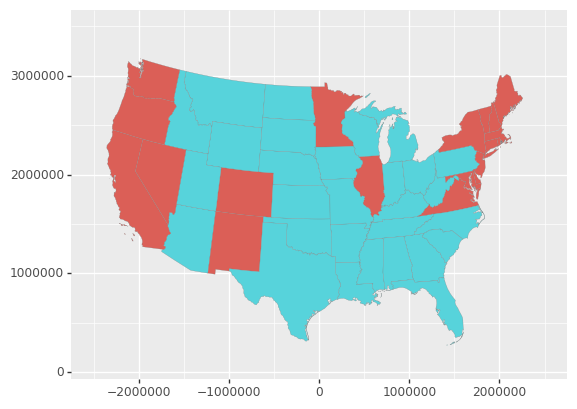

<ggplot: (310390736)>

In [27]:
# Figure 7.6

p = ggplot(data = us_states_elec,
           mapping = aes(fill = 'party'))

(p + geom_map(color = 'gray', size = 0.1) + 
     guides(fill = False) +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000)
)


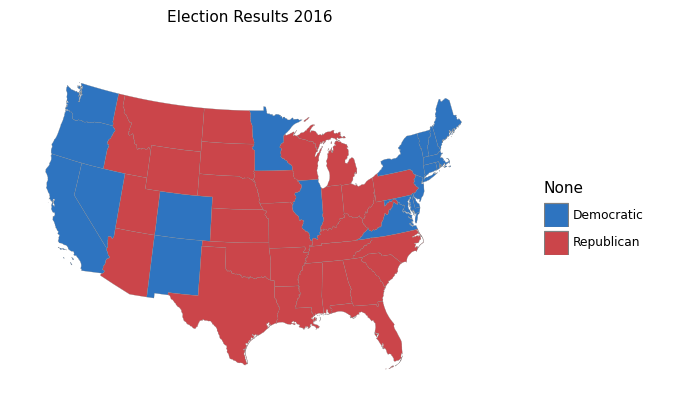

<ggplot: (310497786)>

In [28]:
# Figure 7.7
# Note that we use theme_void() rather than theme_map() to clear away the grid

p = ggplot(data = us_states_elec,
           mapping = aes(fill = 'party'))

(p + geom_map(color = 'gray', size = 0.1) + 
     scale_fill_manual(values = party_colors) + 
 
     labs(title = "Election Results 2016", fill = None) +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)


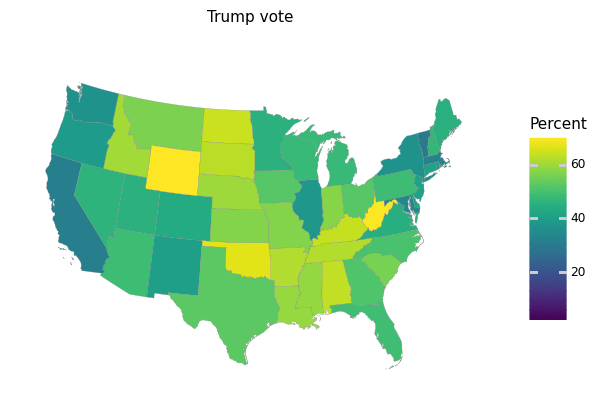

<ggplot: (310531175)>

In [29]:
# Figure 7.8a
# Note that the default color gradient used by plotnine is different
# from that in ggplot (we saw this back in figure 3.17 too)

p = ggplot(data = us_states_elec,
           mapping = aes(fill = 'pct_trump'))

(p + geom_map(color = 'gray', size = 0.1) + 
     # scale_fill_gradient(low = "white", high = "#CB454A") +
 
     labs(title = "Trump vote", fill = 'Percent') +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)


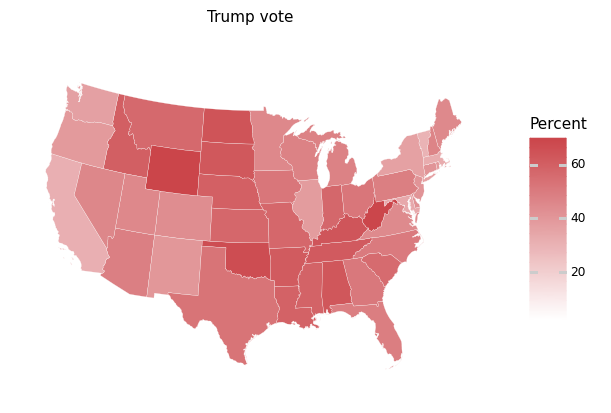

<ggplot: (310572162)>

In [30]:
# Figure 7.8b -- now specify the gradient we want

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient(low = "white", high = "#CB454A") +
 
     labs(title = "Trump vote", fill = 'Percent') +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)


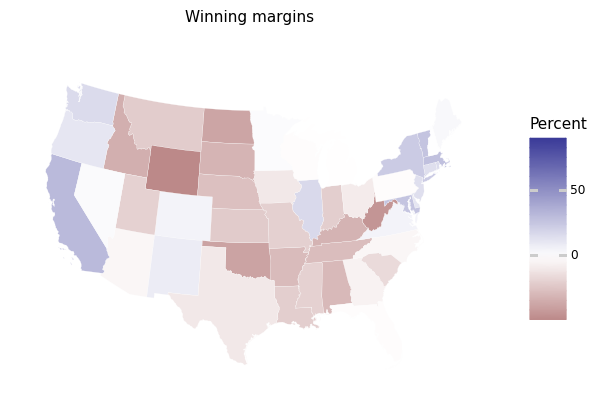

<ggplot: (310612842)>

In [31]:
# Figure 7.9a

p = ggplot(data = us_states_elec,
           mapping = aes(fill = 'd_points'))

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient2() +
 
     labs(title = "Winning margins", fill = 'Percent') +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)


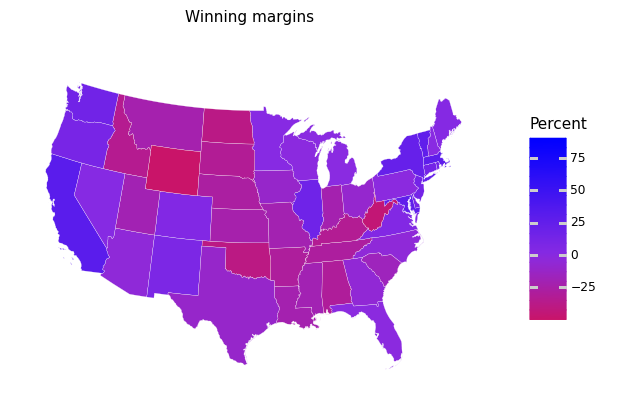

<ggplot: (310655850)>

In [32]:
# Figure 7.9b
# Note: an even better 'mid' choice would be an exact interpolation of red and blue

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient2(low = "red", 
                          mid = 'blueviolet',  # can experiment with different purples here
                          high = "blue", 
                          breaks = (-25, 0, 25, 50, 75)) +
 
     labs(title = "Winning margins", fill = 'Percent') +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)


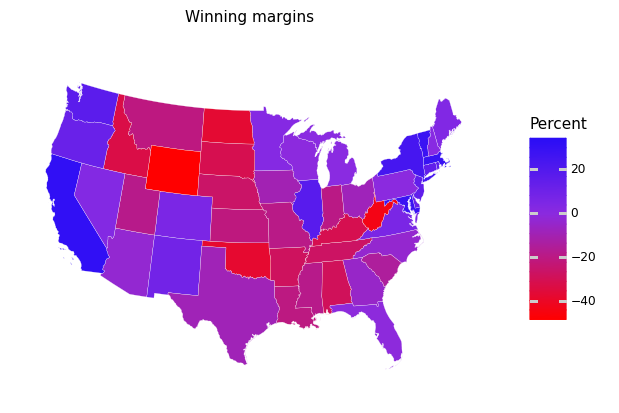

<ggplot: (310699635)>

In [33]:
# Figure 7.10 (filtering out DC)

p = ggplot(data = us_states_elec[us_states_elec['state'] != 'District of Columbia'],
           mapping = aes(fill = 'd_points'))

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient2(low = "red", 
                          mid = 'blueviolet',
                          high = "blue") +
 
     labs(title = "Winning margins", fill = 'Percent') +
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void()
)

### 7.2 America's Ur-choropleths

In [34]:
# Remove Alaska, Hawaii and Puerto Rico from the county data, to keep plot area under control
# Alternative would be to move the location of those polygons, as Healy does

states2remove = ['02', '15', '72']
us_counties_geo = us_counties_geo[~us_counties_geo.STATE.isin(states2remove)]


In [35]:
us_counties_geo.head()  # inspect the dataframe

id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  01001  0500000US01001    01    001   Autauga  County     594.436   
1  01009  0500000US01009    01    009    Blount  County     644.776   
2  01017  0500000US01017    01    017  Chambers  County     596.531   
3  01021  0500000US01021    01    021   Chilton  County     692.854   
4  01033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry  
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...  
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...  
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...  
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...

In [36]:
# Remap to different projection

us_counties_geoY = us_counties_geo.to_crs("EPSG:5070")  # Conus Albers

In [37]:
# Merge county data with map data

county_full = us_counties_geoY.merge(county_data, left_on = "id", right_on = "id")


In [38]:
# Make the population density labels a categorical variable
# and generate more attractive labels to display on the charts
# (in Healy's code, this happens on the fly within the ggplot code)

density_categories_value = ['[    0,   10)', '[   10,   50)', 
                            '[   50,  100)', '[  100,  500)', 
                            '[  500, 1000)', '[ 1000, 5000)', 
                            '[ 5000,71672]']
density_categories_label = ("0-10", "10-50", "50-100", "100-500",
                            "500-1,000", "1,000-5,000", ">5,000")
density_cat_mapping = dict(zip(density_categories_value, density_categories_label))

county_full['pop_densX'] = \
    county_full.apply(lambda row: density_cat_mapping[row['pop_dens']], axis = 1)

# Make sure it is an ordered category
county_full['pop_densX'] = pd.Categorical(county_full['pop_densX'], categories=density_categories_label)


In [39]:
# Generate regularly-spaced discrete intervals from a continuous colormap,
# and map to the categorical variable we want to display (here: population densities)
# (in Healy's code, scale_fill_brewer does this automatically,
#  but plotnine doesn't like mapping categorical values to a continuous color map)

cmap = mpl.cm.Blues  # the continuous color map to use
cmapsize = cmap.N    # generally 256

# extremes are -1 and 256, respectively (i.e. "out of range")
# breaks inbetween must fall in the 0...256 range

nr_vals = 7
intervalsize = cmapsize / (nr_vals - 1)

cmap_indices = [-1,] + \
               [round(x * intervalsize) - 1 for x in range(nr_vals)][1:] + \
               [256,]

color_dict = dict(zip(density_categories_label,
                      [mpl.colors.to_hex(cmap(x)) for x in cmap_indices]))

color_dict

{'0-10': '#f7fbff',
 '10-50': '#d6e6f4',
 '50-100': '#add0e6',
 '100-500': '#6caed6',
 '500-1,000': '#3787c0',
 '1,000-5,000': '#115ca5',
 '>5,000': '#08306b'}

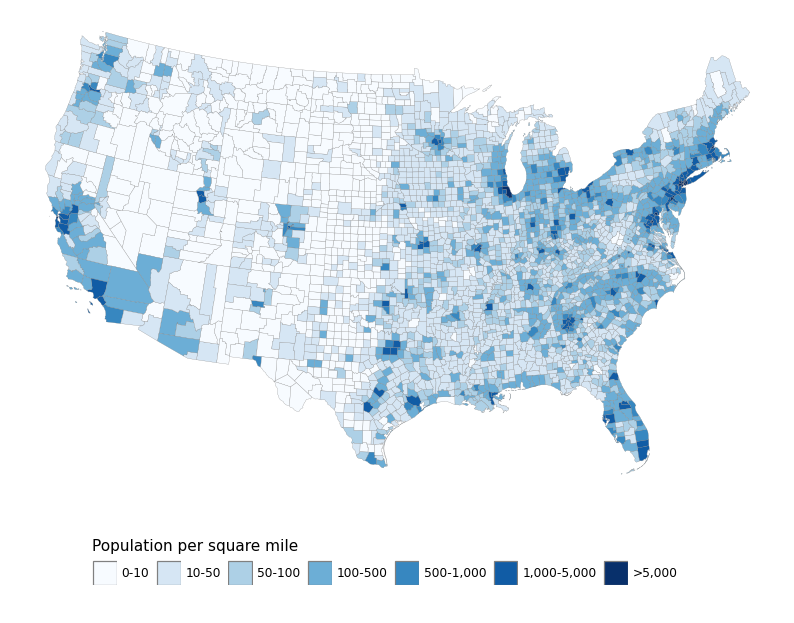

<ggplot: (310312867)>

In [40]:
# Figure 7.11

p = ggplot(data = county_full,
           mapping = aes(fill = 'pop_densX'))

(p + geom_map(color = "gray", size = 0.1) + 
     coord_equal() +
     scale_fill_manual(values = color_dict) + 
     theme_void() + 
     theme(figure_size = (10,6)) +
     guides(fill = guide_legend(nrow = 1)) + 
     labs(fill = "Population per square mile") +
     theme(legend_position = "bottom")
)

In [41]:
# Identify the different labels used to measure % black

county_full['pct_black'].unique()

['[15.0,25.0)', '[ 0.0, 2.0)', '[25.0,50.0)', '[10.0,15.0)', '[50.0,85.3]', '[ 2.0, 5.0)', '[ 5.0,10.0)']
Categories (7, object): ['[ 0.0, 2.0)', '[ 2.0, 5.0)', '[ 5.0,10.0)', '[10.0,15.0)', '[15.0,25.0)', '[25.0,50.0)', '[50.0,85.3]']

In [42]:
# Make the % black labels a categorical variable
# and generate more attractive labels to display on the charts

pct_black_value = ['[ 0.0, 2.0)', '[ 2.0, 5.0)', '[ 5.0,10.0)', '[10.0,15.0)', 
                   '[15.0,25.0)', '[25.0,50.0)', '[50.0,85.3]']
pct_black_label = ("0-2.0", "2.0-5.0", "5.0-10.0", "10.0-15.0",
                   "15.0-25.0", "25.0-50.0", ">50.0")
pct_black_mapping = dict(zip(pct_black_value, pct_black_label))

county_full['pct_blackX'] = \
    county_full.apply(lambda row: pct_black_mapping[row['pct_black']], axis = 1)

# Make sure it is an ordered category
county_full['pct_blackX'] = pd.Categorical(county_full['pct_blackX'], categories=pct_black_label)


In [43]:
county_full.head()  # inspect dataframe

id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  01001  0500000US01001    01    001   Autauga  County     594.436   
1  01009  0500000US01009    01    009    Blount  County     644.776   
2  01017  0500000US01017    01    017  Chambers  County     596.531   
3  01021  0500000US01021    01    021   Chilton  County     692.854   
4  01033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry             name state  \
0  POLYGON ((888385.384 1074625.827, 867146.154 1...   Autauga County    AL   
1  POLYGON ((865138.916 1231675.738, 847724.183 1...    Blount County    AL   
2  POLYGON ((1003933.275 1146037.212, 1010796.039...  Chambers County    AL   
3  POLYGON ((878955.876 1149478.136, 880097.890 1...   Chilton County    AL   
4  POLYGON ((714520.785 1309575.035, 714531.792 1...   Colbert County    AL   

   ... per_dem_2012 per_gop_2012 diff_2012 winner partywinner16  winner12  \
0  ...     0.265758     0.726337     11012  Trump    Republican    Romney   
1  ...     0.123478     0.864929     17780  Trump    Republican    Romney   
2  ...     0.470608     0.521632       743  Trump    Republican    Romney   
3  ...     0.194505     0.797866     10519  Trump    Republican    Romney   
4  ...     0.391888     0.596004      4771  Trump    Republican    Romney   

   partywinner12  flipped  pop_densX  pct_blackX  
0     Republican       No     50-100   15.0-25.0  
1     Republican       No     50-100       0-2.0  
2     Republican       No     50-100   25.0-50.0  
3     Republican       No     50-100   10.0-15.0  
4     Republican       No     50-100   15.0-25.0  

[5 rows x 41 columns]

In [44]:
# Generate discrete intervals from a continuous colormap, now for % black

cmap = mpl.cm.Greens
cmapsize = cmap.N  # generally 256

# extremes are -1 and 256, respectively (i.e. "out of range")
# breaks inbetween must fall in the 0...256 range

nr_vals = 7
intervalsize = cmapsize / (nr_vals - 1)

cmap_indices = [-1,] + \
               [round(x * intervalsize) - 1 for x in range(nr_vals)][1:] + \
               [256,]

color_dict = dict(zip(pct_black_label,
                      [mpl.colors.to_hex(cmap(x)) for x in cmap_indices]))

color_dict

{'0-2.0': '#f7fcf5',
 '2.0-5.0': '#dbf1d6',
 '5.0-10.0': '#afdfa8',
 '10.0-15.0': '#75c477',
 '15.0-25.0': '#37a055',
 '25.0-50.0': '#0c7735',
 '>50.0': '#00441b'}

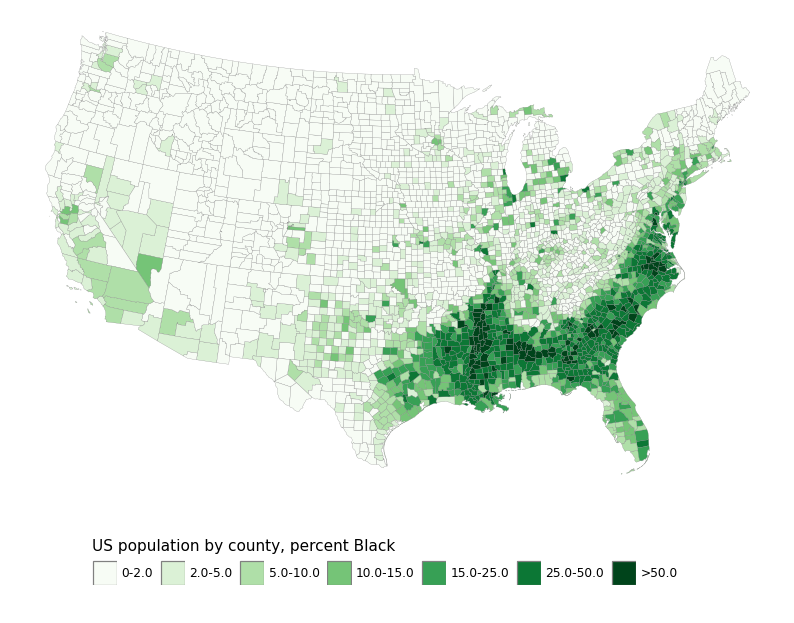

<ggplot: (310869477)>

In [45]:
# Figure 7.12

p = ggplot(data = county_full,
           mapping = aes(fill = 'pct_blackX'))

(p + geom_map(color = "gray", size = 0.1) + 
     coord_equal() +
     scale_fill_manual(values = color_dict) + 
     theme_void() + 
     theme(figure_size = (10,6)) +
     guides(fill = guide_legend(nrow = 1)) + 
     labs(fill = "US population by county, percent Black") +
     theme(legend_position = "bottom")
)


In [46]:
# Generate discrete intervals from a continuous colormap
# In Healy's case, the extremes of the color range do not appear to be included, 
# so ask for 2 extra, then drop extremes

cmap = mpl.cm.Oranges
cmapsize = cmap.N  # generally 256

# extremes are -1 and 256, respectively (i.e. "out of range")
# breaks inbetween must fall in the 0...256 range

nr_vals = 8
intervalsize = cmapsize / (nr_vals - 1)

cmap_indices = [-1,] + \
               [round(x * intervalsize) - 1 for x in range(nr_vals)][1:] + \
               [256,]

orange_pal = [mpl.colors.to_hex(cmap(x)) for x in cmap_indices][1:-1]
orange_pal

['#fee3c8', '#fdc794', '#fda057', '#f67925', '#e05206', '#ae3903', '#7f2704']

In [47]:
# Reverse order
orange_rev = orange_pal[::-1]

In [48]:
# Identify unique values

county_full['su_gun6'].unique()

['[10,12)', '[ 8,10)', '[ 4, 7)', '[12,54]', '[ 7, 8)', '[ 0, 4)']
Categories (6, object): ['[ 0, 4)', '[ 4, 7)', '[ 7, 8)', '[ 8,10)', '[10,12)', '[12,54]']

In [49]:
# Make categorical and generate cleaner labels

varname = 'su_gun6'
targetvar = varname + 'X'

vals = ['[ 0, 4)', '[ 4, 7)', '[ 7, 8)', '[ 8,10)', '[10,12)', '[12,54]']
labels = ("0-4", "4-7", "7-8", "8-10", "10-12", "12-54")

mapping = dict(zip(vals, labels))

county_full[targetvar] = \
    county_full.apply(lambda row: mapping[row[varname]], axis = 1)

# Make sure it is an ordered category
county_full[targetvar] = pd.Categorical(county_full[targetvar], categories=labels)

su_labels = labels

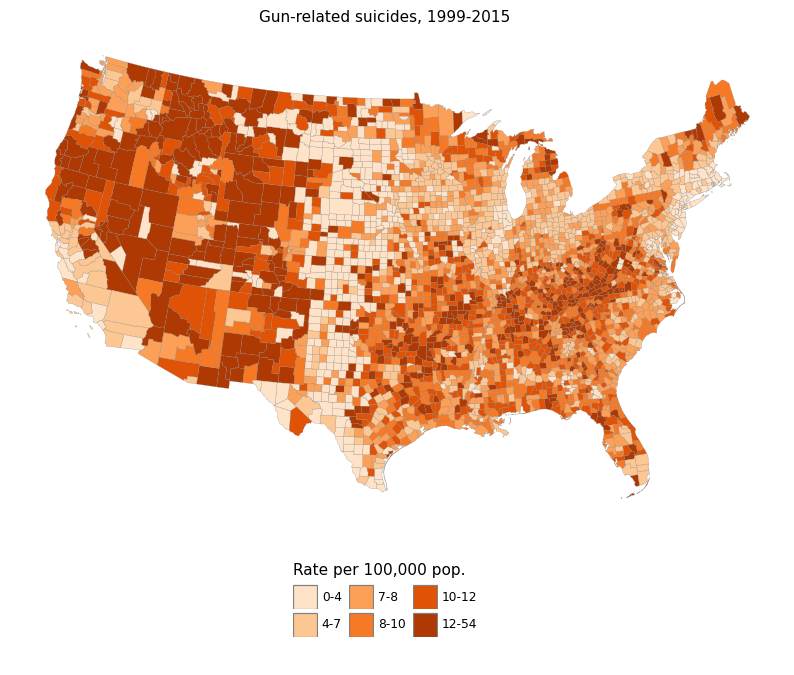

<ggplot: (310486197)>

In [50]:
# Figure 7.13a
# We are storing the figure in a variable, so we can combine it with 7.13b later.
# This will be done with patchworklib, which does not know about the 'nrow' guide_legend
# option, so we have to comment that out

# Note that we're linking the color list to the labels on the fly here,
# instead of pre-generating the dictionary as above

gun_p = ggplot(data = county_full,
               mapping = aes(fill = county_full['su_gun6X']))

gun_plot = \
(gun_p + \
     geom_map(color = "gray", size = 0.1) + 
     coord_equal() +
     scale_fill_manual(values = dict(zip(su_labels, orange_pal))) + 
     theme_void() + 
     theme(figure_size = (10,6)) +
     # guides(fill = guide_legend(nrow = 1)) + 
     labs(title = "Gun-related suicides, 1999-2015",
          fill = 'Rate per 100,000 pop.') +
     theme(legend_position = "bottom")
)

gun_plot

In [51]:
# Get unique ranges for population densities

county_full['pop_dens6'].unique()

['[ 82,  215)', '[ 45,   82)', '[  9,   25)', '[215,71672]', '[  0,    9)', '[ 25,   45)']
Categories (6, object): ['[  0,    9)', '[  9,   25)', '[ 25,   45)', '[ 45,   82)', '[ 82,  215)', '[215,71672]']

In [52]:
# Make categorical and assign cleaner labels

varname = 'pop_dens6'
targetvar = varname + 'X'

vals = ['[  0,    9)', '[  9,   25)', '[ 25,   45)', '[ 45,   82)', '[ 82,  215)', '[215,71672]']
labels = ("0-9", "9-25", "25-45", "45-82", "82-215", ">215")

mapping = dict(zip(vals, labels))

county_full[targetvar] = \
    county_full.apply(lambda row: mapping[row[varname]], axis = 1)

# Make sure it is an ordered category
county_full[targetvar] = pd.Categorical(county_full[targetvar], categories=labels)

dens_labels = labels

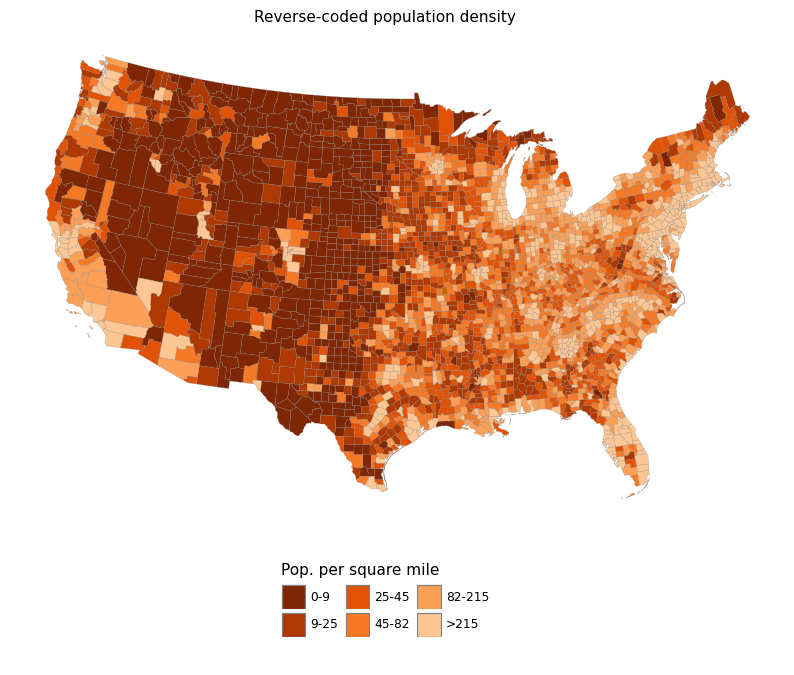

<ggplot: (311035411)>

In [53]:
# Figure 7.13b

pop_p = ggplot(data = county_full,
               mapping = aes(fill = county_full['pop_dens6X']))

dens_plot = \
(pop_p + \
     geom_map(color = "gray", size = 0.1) + 
     coord_equal() +
     scale_fill_manual(values = dict(zip(dens_labels, orange_rev))) + 
     theme_void() + 
     theme(figure_size = (10,6)) +
     # guides(fill = guide_legend(nrow = 1)) + 
     labs(title = "Reverse-coded population density",
          fill = 'Pop. per square mile') +
     theme(legend_position = "bottom")
)

dens_plot

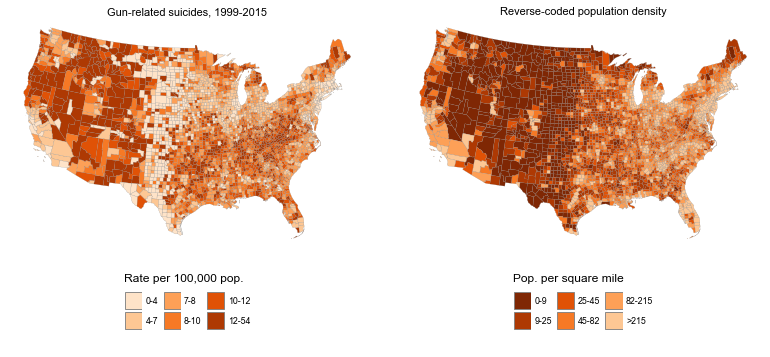

In [54]:
# Fig. 7.13 with the maps side-by-side
# Note that patchworklib is a bit finicky:
# - it insists on specifying df name in the aes,
#   and it does not know 'nrow' as an option for legend arrangement

g1 = pw.load_ggplot(gun_plot, figsize=(5, 5))
g2 = pw.load_ggplot(dens_plot, figsize=(5, 5))
g1next2 = g1|g2
g1next2.savefig()

### 7.3 Statebins

Rather than turn to a separate package `statebins`, we simply use a geojson file defining the states as squares in a standard arrangement. This means we can continue to use `plotnine` with all its features.

In [55]:
# Rename the state square name column to match with our other data
us_states_square.rename(columns = {'name': 'state'}, inplace = True)


In [56]:
# Extract central location within each state square

us_states_square['centroid'] = us_states_square['geometry'].centroid

In [57]:
us_states_square.head()

id abbr          state                                           geometry  \
0   1   ME          Maine  POLYGON ((-89.75000 45.75000, -88.75000 45.750...   
1   2   NH  New Hampshire  POLYGON ((-89.75000 44.50000, -88.75000 44.500...   
2   3   VT        Vermont  POLYGON ((-91.00000 44.50000, -90.00000 44.500...   
3   4   MA  Massachusetts  POLYGON ((-91.00000 43.25000, -90.00000 43.250...   
4   5   NY       New York  POLYGON ((-92.25000 43.25000, -91.25000 43.250...   

                     centroid  
0  POINT (-89.25000 45.25000)  
1  POINT (-89.25000 44.00000)  
2  POINT (-90.50000 44.00000)  
3  POINT (-90.50000 42.75000)  
4  POINT (-91.75000 42.75000)

In [58]:
# Extract individual coordinates of the center of each square, 
# to use as location for placing state abbrev.

us_states_square['x'] = us_states_square['centroid'].x
us_states_square['y'] = us_states_square['centroid'].y
us_states_square.head()

id abbr          state                                           geometry  \
0   1   ME          Maine  POLYGON ((-89.75000 45.75000, -88.75000 45.750...   
1   2   NH  New Hampshire  POLYGON ((-89.75000 44.50000, -88.75000 44.500...   
2   3   VT        Vermont  POLYGON ((-91.00000 44.50000, -90.00000 44.500...   
3   4   MA  Massachusetts  POLYGON ((-91.00000 43.25000, -90.00000 43.250...   
4   5   NY       New York  POLYGON ((-92.25000 43.25000, -91.25000 43.250...   

                     centroid      x      y  
0  POINT (-89.25000 45.25000) -89.25  45.25  
1  POINT (-89.25000 44.00000) -89.25  44.00  
2  POINT (-90.50000 44.00000) -90.50  44.00  
3  POINT (-90.50000 42.75000) -90.50  42.75  
4  POINT (-91.75000 42.75000) -91.75  42.75

In [59]:
# Merge with our state data

us_states_elec2 = us_states_square.merge(election, left_on = 'state', right_on = 'state')

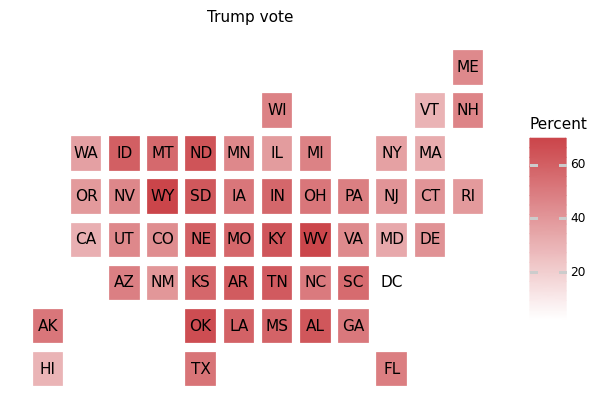

<ggplot: (310345373)>

In [60]:
# Figure 7.14a

p = ggplot(data = us_states_elec2,
           mapping = aes(fill = 'pct_trump'))

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient(low = "white", high = "#CB454A") +
     geom_text(mapping = aes(label = 'abbr', x = 'x', y = 'y')) +
 
     labs(title = "Trump vote", fill = 'Percent') +
     theme_void()
)


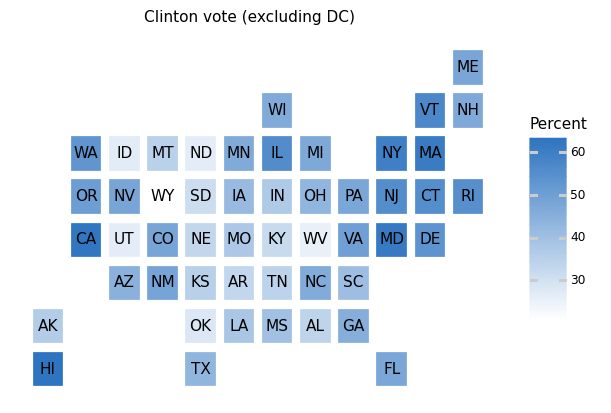

<ggplot: (309925313)>

In [61]:
# Figure 7.14b

p = ggplot(data = us_states_elec2[us_states_elec2['state'] != 'District of Columbia'],
           mapping = aes(fill = 'pct_clinton'))

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_gradient(low = "white", high = "#2E74C0") +
     geom_text(mapping = aes(label = 'abbr', x = 'x', y = 'y')) +
 
     # It is good practice to specify inclusions/exclusions explicitly
     labs(title = "Clinton vote (excluding DC)", fill = 'Percent') +
     theme_void()
)


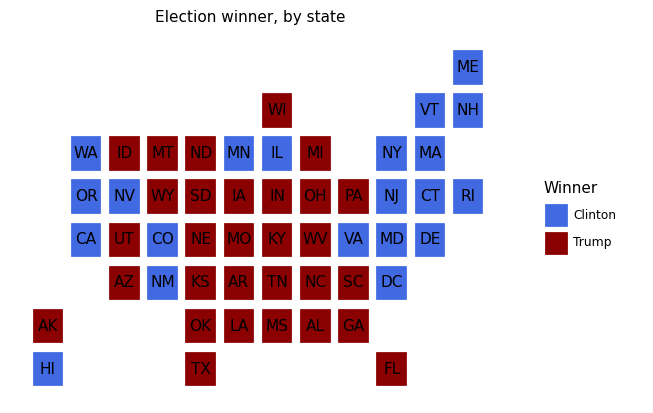

<ggplot: (311162856)>

In [62]:
# Figure 7.15a
# Note that we do not need to generate a new variable/column with color

p = ggplot(data = us_states_elec2,
           mapping = aes(fill = 'party'))

(p + geom_map(color = 'white', size = 0.1) + 
     geom_text(mapping = aes(label = 'abbr', x = 'x', y = 'y')) +
     scale_fill_manual(values = {'Republican': 'darkred',
                                 'Democratic': 'royalblue'},
                       labels = ('Clinton', 'Trump')) + 
                         
     labs(title = "Election winner, by state", fill = 'Winner') +
     theme_void()
)


In [63]:
# Generate discrete intervals from a continuous colormap
# Ask for 1 extra and take the lighter ones only, to match Healy's colors

cmap = mpl.cm.Reds
cmapsize = cmap.N  # generally 256

# extremes are -1 and 256, respectively (i.e. "out of range")
# breaks inbetween must fall in the 0...256 range

nr_vals = 6
intervalsize = cmapsize / (nr_vals - 1)

cmap_indices = [-1,] + \
               [round(x * intervalsize) - 1 for x in range(nr_vals)][1:] + \
               [256,]

reds4 = [mpl.colors.to_hex(cmap(x)) for x in cmap_indices][1:-2]
reds4

['#fdcbb6', '#fc8b6b', '#f14432', '#bc141a']

In [64]:
pct_trump_labels = ['4-21', '21-37', '37-53', '53-70']

In [65]:
# Generate a categorical variable to match the labels

def getrange(pctval, rangelabels):
    returnval = ''
    for range_str in rangelabels:
        low, high = range_str.split('-')
        if pctval >= int(low) and pctval < int(high):
            returnval = range_str
            break
            
    if returnval == '':
        print('error!', pctval)
        
    return returnval

us_states_elec2['pct_trump_range'] = us_states_elec2.apply(lambda row: getrange(row['pct_trump'], pct_trump_labels), axis = 1)

# Make sure it is an ordered category
us_states_elec2['pct_trump_range'] = pd.Categorical(us_states_elec2['pct_trump_range'], categories=pct_trump_labels)


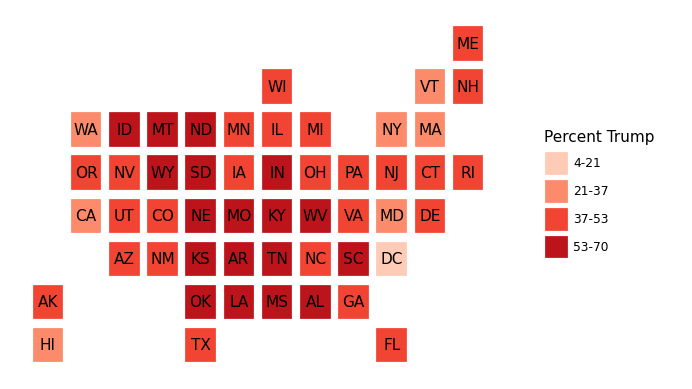

<ggplot: (310455342)>

In [66]:
# Figure 7.15b

p = ggplot(data = us_states_elec2,
           mapping = aes(fill = 'pct_trump_range'))

(p + geom_map(color = 'white', size = 0.1) + 
 
     scale_fill_manual(values = dict(zip(pct_trump_labels, reds4))) + 

     geom_text(mapping = aes(label = 'abbr', x = 'x', y = 'y')) +
                         
     labs(fill = 'Percent Trump') +
     theme_void()
)


### 7.4 Small-multiple maps

In [67]:
# Merge opiates data with our states data from before (section 7.1)

opiates_map = us_states_geoY.merge(opiates, left_on = 'state', right_on = 'state')

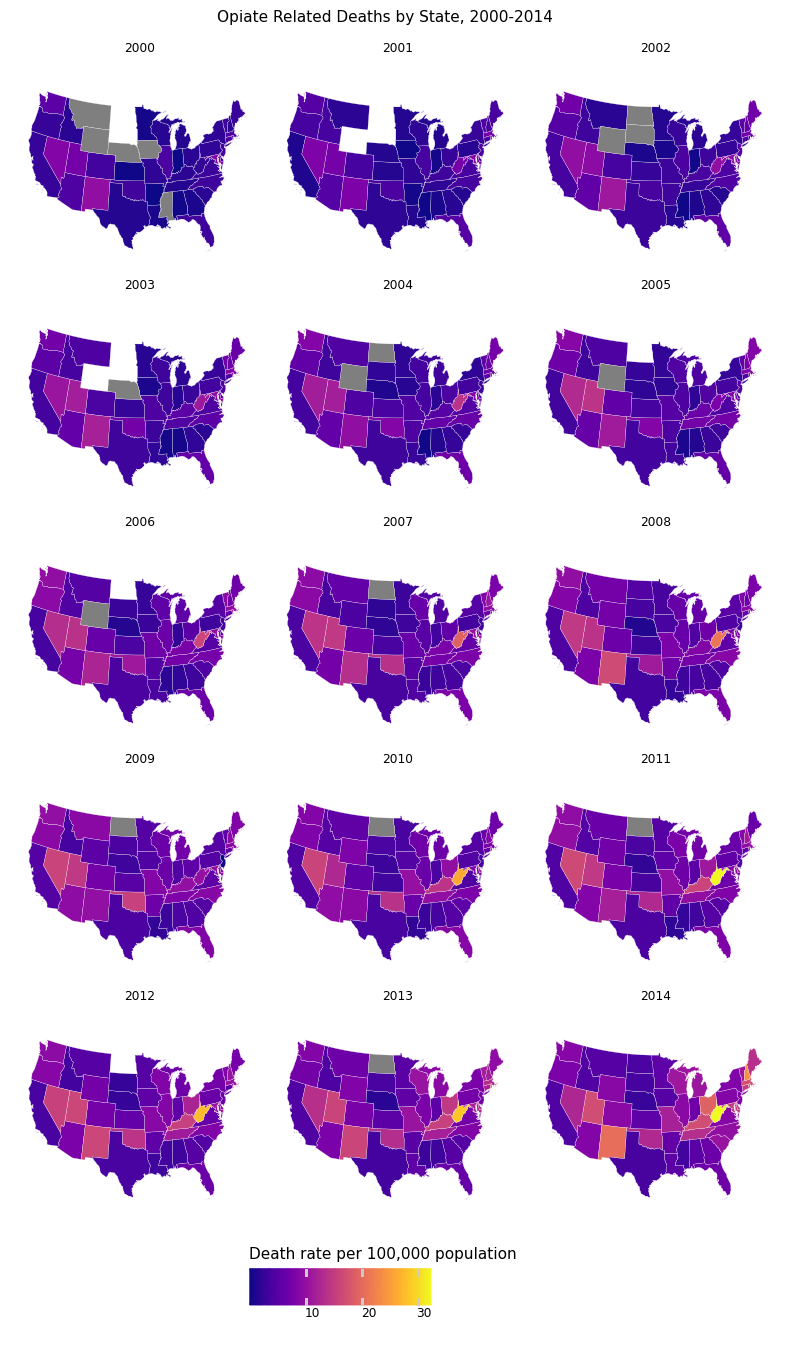

<ggplot: (310828921)>

In [68]:
# Figure 7.16

p = ggplot(data = opiates_map[opiates_map['year'] > 1999],
           mapping = aes(fill = 'adjusted'))

(p + geom_map(color = 'white', size = 0.1) + 
     scale_fill_cmap(cmap_name = 'plasma') + 
 
     facet_wrap('year', ncol = 3) +
  
     labs(fill = "Death rate per 100,000 population ",
          title = "Opiate Related Deaths by State, 2000-2014") +
 
     xlim(-2500000, 2500000) +
     ylim(100000, 3500000) +
     theme_void() +
 
     theme(legend_position = "bottom",
           strip_background = element_blank(),
           figure_size = (10, 15))
)


### 7.5 Is your data really spatial?

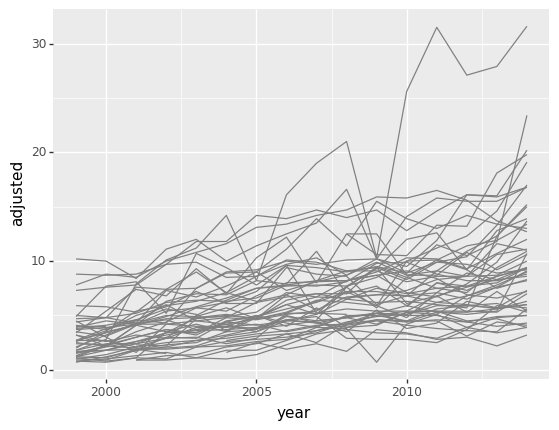

<ggplot: (311137946)>

In [69]:
# Figure 7.17

p = ggplot(data = opiates,
           mapping = aes(x = 'year', y = 'adjusted', group = 'state'))

p + geom_line(color = 'gray')

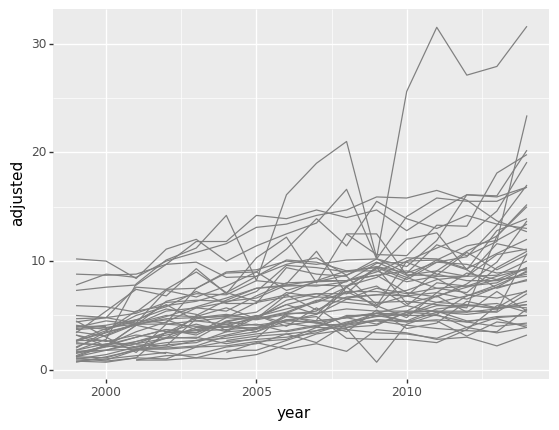

<ggplot: (311367699)>

In [70]:
# First code snippet after figure 7.17 (produces unnumbered figure, same as 7.17)

p = ggplot(data = opiates[opiates.state != 'District of Columbia'],
           mapping = aes(x = 'year', y = 'adjusted'))

p + geom_line(color = 'gray',
              mapping = aes(group = 'state')) 


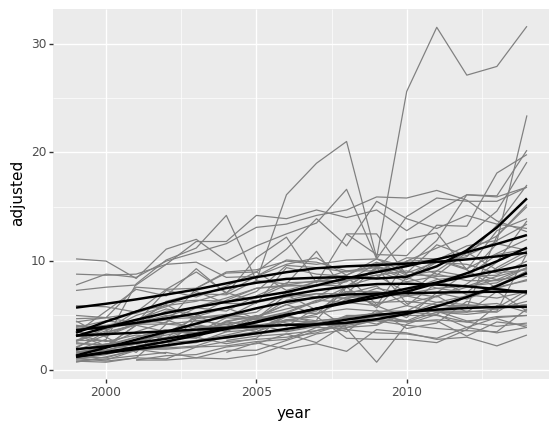

<ggplot: (310890614)>

In [71]:
# Adding in code from the next code snippet (adds division smoother)

p + geom_line(color = 'gray',
              mapping = aes(group = 'state')) + \
    geom_smooth(mapping = aes(group = 'division_name'),
                se = False)


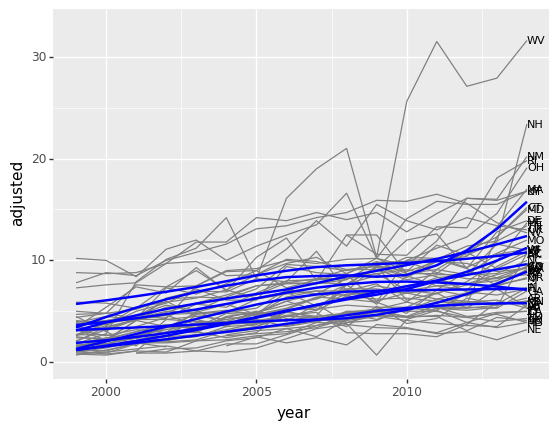

<ggplot: (311089734)>

In [72]:
# Adding in code from the next code snippet (adds text labels)

# For some reason adjust_text does not work. Worth figuring out why!

maxyear = max(opiates['year'])
minyear = min(opiates['year'])

(p + geom_line(color = 'gray',
              mapping = aes(group = 'state')) + 
     geom_smooth(mapping = aes(group = 'division_name'),
                se = False, color = 'blue') + 
     geom_text(data = opiates[(opiates['abbr'] != 'DC') & \
                              (opiates['year'] == maxyear)],
               mapping = aes(label = 'abbr'),
               ha = 'left', 
               size = 8,
               # adjust_text = {'expand_points': (1.5, 1.5),
               #                'arrowprops': {'arrowstyle': '-'}},
               show_legend = False) +
     coord_cartesian(xlim = (minyear, maxyear),
                    ylim = (0, 33))
)


In [73]:
# Sort regions by average adjusted death rate (averaged across states & years)

meandeathrate = []
for groupname, groupdata in opiates.groupby('division_name'):
    meandeathrate.append((groupdata['adjusted'].mean(), groupname))
    
orderedlist = [groupname for _, groupname in sorted(meandeathrate, reverse = True)]
opiates['orderedvar'] = pd.Categorical(opiates['division_name'], categories=orderedlist)


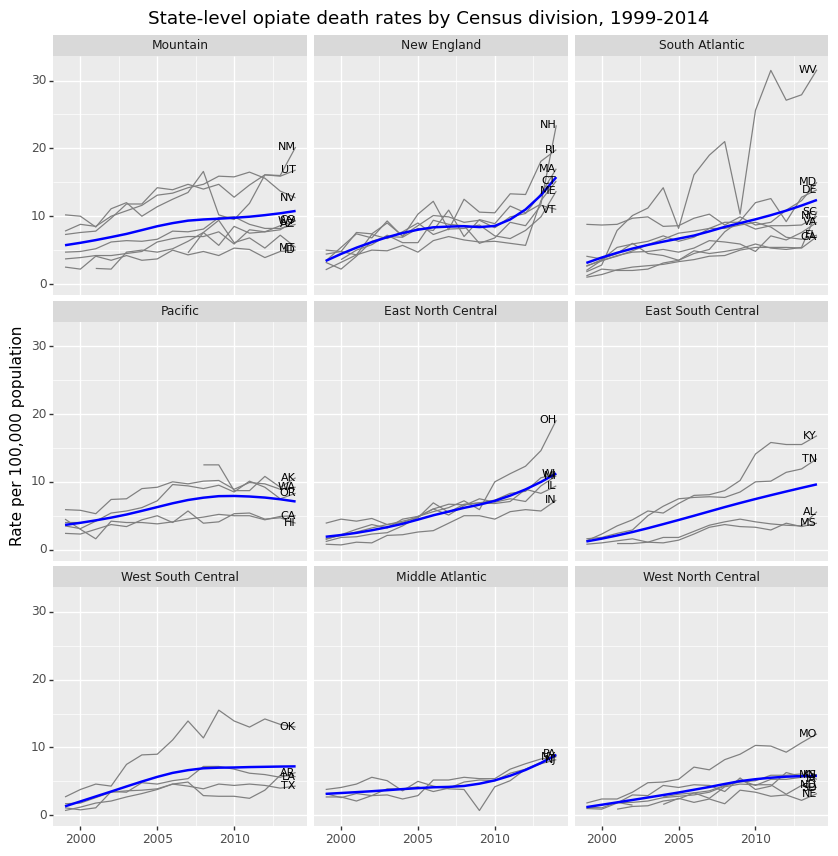

<ggplot: (322304428)>

In [74]:
# Figure 7.18 
# Note the poor labeling of state names, due to adjust_text not working
# Fortunately the outlier names in each region are clearly legible

p = ggplot(data = opiates[opiates['abbr'] != 'DC'],
          mapping = aes(x = 'year', y = 'adjusted', group = 'state'))

(p + geom_line(color = 'gray',
               mapping = aes(group = 'state')) + 
     geom_smooth(mapping = aes(group = 'orderedvar'),
                 se = False, color = 'blue') + 
     geom_text(data = opiates[(opiates['abbr'] != 'DC') & \
                              (opiates['year'] == maxyear)],
               mapping = aes(label = 'abbr'),
               ha = 'right', size = 8) +
               # adjust_text = {'expand_points': (1.5, 1.5),
               #                'arrowprops': {'arrowstyle': '-'}}) + \
     facet_wrap('orderedvar', nrow = 3) + 
     coord_cartesian(xlim = (minyear, maxyear),
                     ylim = (0, 32)) + 
     labs(x = '', y = 'Rate per 100,000 population',
          title = 'State-level opiate death rates by Census division, 1999-2014') + 
     theme(figure_size = (10, 10))
)


### This completes the figures for chapter 7